__I - Instalation of libraries and listing directories of data.__

In [ ]:
pip install --upgrade pyabf

In [334]:
import pyabf
import pyabf.tools.memtest 
import matplotlib.pyplot as plt
import numpy as np
import os 
import os.path
from os import path
import csv
import pandas as pnd

import warnings
warnings.filterwarnings("ignore")

Specify directory with data. In the final version of this script the ideal scenario for file handling would be that a master list containing each individual experiment is read and the pipeline run individually for each .abf file inside folders corresponding to each cell. The quantifications would be saved in a .csv containing columns for: name of cell and experiment, measurements, and important metadata such as type of experiment and date. 

In [451]:
# Functions and stuff I will implement to semi-automate the pipeline to account for alll cells/experiments in cd

#change directory
os.chdir('/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/171219_SCH-028953/028953slice1cell1')
#os.chdir('/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/171219_SCH-028953/Test file') 
cwd = os.getcwd()

if path.exists('.DS_Store') == True: # my own computer creates this given that i use a backup drive, 
                                     #you can comment this out but
                                     # it shouldn't disrupt anything
        os.remove('.DS_Store')

#generate array of filenames in directory
contents = os.listdir('.')
print(contents)

['19d18005.abf_header.csv', '19d18002.abf_header.csv', '19d18003.abf_header.csv', '19d18004.abf_header.csv', '19d18006.abf_header.csv', '19d18009.abf_header.csv', '19d18009.abf', '19d18008.abf', '19d18001.abf_header.csv', '19d18000.abf_header.csv', '19d18008.abf_header.csv', '19d18007.abf_header.csv', '19d18002.abf_header.txt', '19d18003.abf', '19d18002.abf', '19d18005.abf_header.txt', '19d18000.abf', '19d18001.abf', '19d18005.abf', '19d18004.abf_header.txt', '19d18004.abf', '19d18006.abf', '19d18003.abf_header.txt', '19d18007.abf', '19d18009.abf_header.txt', '19d18001.abf_header.txt', '19d18006.abf_header.txt', '19d18007.abf_header.txt', '19d18000.abf_header.txt', '19d18008.abf_header.txt']


__II - Pre-processing and visualization__ <br>



First we generate txt files out of the header information in each ABF for easier access to variables. For now we keep these in case the .csv files down the line cause trouble.

In [452]:
abf_files = len(contents)
print(abf_files)
print(contents)    
header_files = []
for i in range(abf_files):
    if '.txt' not in contents[i] and '.csv' not in contents[i]:
        #print(contents[i])
        header_txt = contents[i] + '_header.txt'
        header = open(header_txt,'w')
        header_files.append(header_txt)
        abf = pyabf.ABF(contents[i])
        header.write(abf.headerText)
        header.close()
    
    elif '.txt' in contents[i] and '.csv' not in contents[i]:
        header_files.append(contents[i]) 


30
['19d18005.abf_header.csv', '19d18002.abf_header.csv', '19d18003.abf_header.csv', '19d18004.abf_header.csv', '19d18006.abf_header.csv', '19d18009.abf_header.csv', '19d18009.abf', '19d18008.abf', '19d18001.abf_header.csv', '19d18000.abf_header.csv', '19d18008.abf_header.csv', '19d18007.abf_header.csv', '19d18002.abf_header.txt', '19d18003.abf', '19d18002.abf', '19d18005.abf_header.txt', '19d18000.abf', '19d18001.abf', '19d18005.abf', '19d18004.abf_header.txt', '19d18004.abf', '19d18006.abf', '19d18003.abf_header.txt', '19d18007.abf', '19d18009.abf_header.txt', '19d18001.abf_header.txt', '19d18006.abf_header.txt', '19d18007.abf_header.txt', '19d18000.abf_header.txt', '19d18008.abf_header.txt']


Then we generate a table from different sections of the txt file to organize the values from the protocol used in the experiment and make them accessible to our code. We then have a pandas Dataframe with all of the metadata we will need to analyze our experiment. However, it exists as a set of strings in a single column, which isn't useful. Using the pandas 'str.split' function on each cell allows us to turn this one-column table into two columns, the one on the right showing our values of interest. 

In [453]:

num_files = len(header_files)
csv_files = []

for i in range(num_files):
    if '.csv' not in header_files[i] and '.txt' in header_files[i]:
        
        header = open(header_files[i],'r')
        metadata_str = []
    
        for line in header:
            if '=' in line:
                metadata_str.append(line)
            
        csv_filename = header_files[i].replace('.txt','.csv')
        metadata_csv = pnd.DataFrame(metadata_str)
        
        metadata_csv.columns = ['Data'] # pandas doesn't like column names to be 0 
        metadata_csv[['Data','Values']] = metadata_csv.Data.str.split(" = ",expand=True) # remove whitespaces too!!!
        metadata_csv.to_csv(csv_filename, sep=',',index=False)
        csv_files.append(csv_filename)
        
print(csv_files)


#MAKE A LINE THAT TURNS THESE CVS INTO LIBRARIES THIS IS A GOOD IDEA YES

['19d18009.abf_header.csv', '19d18008.abf_header.csv', '19d18002.abf_header.csv', '19d18003.abf_header.csv', '19d18002.abf_header.csv', '19d18005.abf_header.csv', '19d18000.abf_header.csv', '19d18001.abf_header.csv', '19d18005.abf_header.csv', '19d18004.abf_header.csv', '19d18004.abf_header.csv', '19d18006.abf_header.csv', '19d18003.abf_header.csv', '19d18007.abf_header.csv', '19d18009.abf_header.csv', '19d18001.abf_header.csv', '19d18006.abf_header.csv', '19d18007.abf_header.csv', '19d18000.abf_header.csv', '19d18008.abf_header.csv']


The format of our data folder includes a first file with a membrane test, where we can find the input resistance and series resistance for the cell in that experiment. These sweeps also contain a spectrum of different presynaptic stimulation currents. .

The following plot shows the x axes as time in seconds (an internally generated variable in the ABF file) and each dataframe, which can help us choose our index values i1 and i2. 


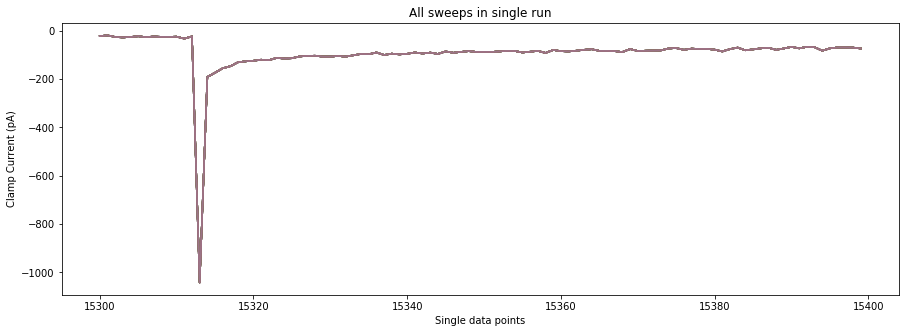

In [454]:
# Plot all sweeps in a single run

abf = pyabf.ABF("19d18000.abf") #specified

plt.figure(figsize=(15, 5))
plt.title("All sweeps in single run")
plt.ylabel(abf.sweepLabelY)
plt.xlabel('Single data points')

frame_axis = range(abf.sweepPointCount) # one of the few cases where the class variables are accessible


#i1, i2 = 0, abf.sweepPointCount # quick fix to look at the whole trace or chunk, uncomment one of these two
i1, i2 = 15300, 15400


dataY = abf.sweepY[i1:i2]
#dataX = abf.sweepX[i1:i2]
dataX = frame_axis[i1:i2]
for i in abf.sweepList:
    abf.setSweep(i)
    plt.plot(dataX, dataY, alpha=.5)
plt.show()


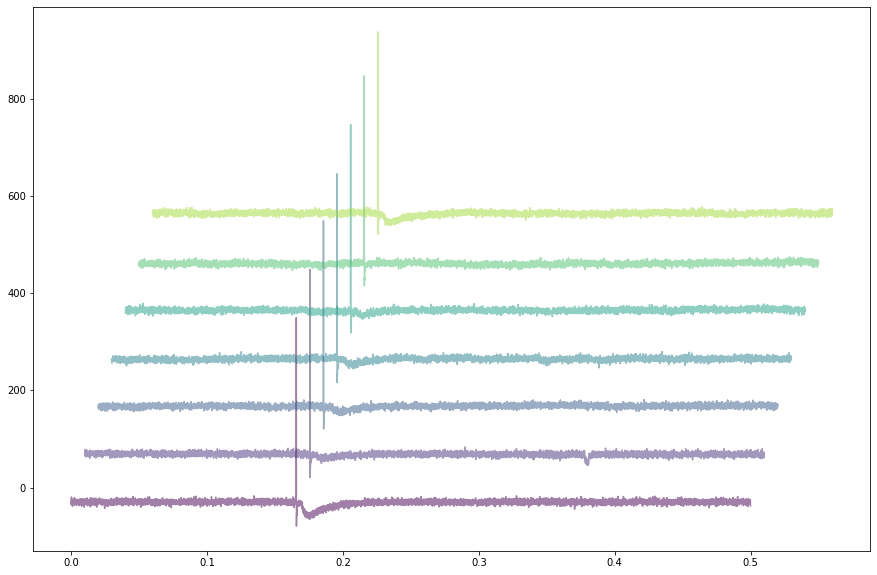

In [339]:
# Plot all sweeps with 3D offset to see each trace in more detail

abf = pyabf.ABF("19d18001.abf") #specified

plt.figure(figsize=(15, 10))

#Make colormap to distinguish sweeps
cm = plt.get_cmap("viridis")
colors = [cm(x/abf.sweepCount) for x in abf.sweepList]

for i in abf.sweepList:
    
    abf.setSweep(i)
    # Plot part of the sweep. sweepPointCount is total number of datapoints per sweep,
    # I used fractions to restrict plotting to only the second half of the sweep
    i1, i2 = 0, 10000
    
    
    dataX = abf.sweepX[i1:i2] + .010 * i #offsets are toggled around manually until clear picture is visible
    dataY = abf.sweepY[i1:i2] + 100 * i
    plt.plot(dataX, dataY, alpha=.5, color=colors[i]) #applies colormap

#plt.gca().axis('off')  # hide axes to enhance floating effect
plt.show()

__III - EPSC analysis__

We know that the main factors that contribute to input (membrane) resistance are: size of the cell, health of cell, channel composition of membrane, and other naturally occuring effects that can vary between cells and experiments. Another form of resistance that arises due to experimental design is series resistance, which partly depends on the physical properties of the cell but also on the dimensions of the pipette and capacitance of the ephys components. Both of these measures can serve as a way to monitor the quality of the prep overall and as the experiment progresses with different sweeps. <br>

We first start by restricting our window of analysis to only the first abf per folder, which contains a membrane test and tells us the state of the cell right before the experimental sweeps. This experiment has a command waveform that can be plotted along with its current output in the cell.


-Big peak (capacitative current) serves to see health of cell throughout experiment.
-Holding potential is actually -63 + liquid junction potential

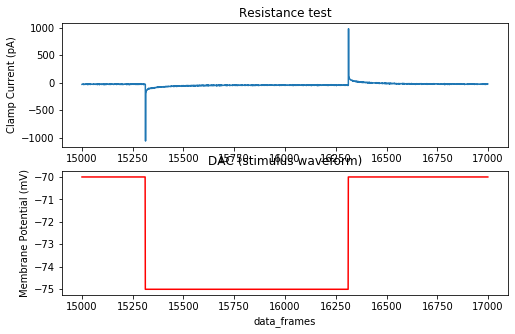

In [460]:
# Plot command waveform with abf.sweepC (only applies to current injection, not synaptic stimulation)
abf.setSweep(1) # Just a trial run, but this is a key part of other functions to index through sweeps!    
i1, i2 = 15000, 17000
frame_axis = range(abf.sweepPointCount)

fig = plt.figure(figsize=(8, 5))

ax1 = fig.add_subplot(211)
ax1.set_title("Resistance test")
ax1.plot(frame_axis[i1:i2], abf.sweepY[i1:i2])

real_mV = abf.sweepC - 70; # traces are saved as 0 = -70 mV

# plot the DAC (clamp current)
ax2 = fig.add_subplot(212, sharex=ax1)  # <-- this argument is new
ax2.set_title("DAC (stimulus waveform)")
ax2.plot(frame_axis[i1:i2], real_mV[i1:i2], color='r')
ax1.set_ylabel(abf.sweepLabelY)
ax2.set_xlabel('data_frames')
ax2.set_ylabel(abf.sweepLabelC)

plt.show()

It seems like there are specific start and end points for the waveform that we could use to restrict our analysis window. These are saved in the metadata as sweepEpochs, which we can access from the csv using pandas. Dataframes are useful for storing this type of metadata, but they would be quicker to work with in this case if we switch them into dictionaries, given that there are only two columns named 'Data' and 'Value' in the csv. 

We will need to parse out some of these values as we attempt to implement them since that they are saved in the csv as strings. Some of the functions below will be used freely, while some are useful only for parsing out a specific parameter in the metadata.

In [456]:
def get_metadata_values(csv,parameter):

    # Obtains raw data string associated to specified parameter in metadata.
    csv_metadata = pnd.read_csv(csv)
    dic_metadata = csv_metadata.set_index('Data').to_dict()['Values'] # totally stolen from stack overflow and its FAST
    raw_str = dic_metadata[parameter] 
    return raw_str
def get_mV_step_interval(raw_str):
    # assumes only a single voltage step in voltage clamp experiments
    parsed_str = raw_str.split(', ')
    parsed_total = (len(parsed_epochs))
    for i in range(parsed_total):
        if '0.00' not in parsed_str[i]:
            # also stolen: this extracts string inside []
            values = parsed_str[i][parsed_str[i].find("[")+1:parsed_str[i].find("]")]
    step_points = (values.split(':'))
    step_start, step_end = int(step_points[0]), int(step_points[1])
    return step_start, step_end


We obtain the start and end values of the voltage step that we can use to obtain the currents at the onset of the step, where the capacitative current is seen, and the tailing end of the step, where we can more reliably estimate the input resistance.

In [459]:
parameter = 'sweepEpochs'
values = get_metadata_values(csv_files[1],parameter)    

step_start, step_end = get_mV_step_interval(values)
neg_maxI = min(abf.sweepY) # we don't need windows because this is the biggest signal in the whole experiment
neg_max_ind = np.argmin(abf.sweepY) #find index for this value **** WILL PROBABLY USE THIS STRATEGY A LOT

Rs = (real_mV[neg_max_ind]/neg_maxI) * 1000 #convert from gigaohms to megaohms
print('Series resistance = ', Rs, 'MegaOhms')


Input_I = abf.sweepY[step_end - 10]
Ri = (real_mV[step_end - 10]/Input_I) * 1000
print('Input resistance = ', Ri, 'MegaOhms')



Series resistance =  70.86505190311419 MegaOhms
Input resistance =  1755.4285714285713 MegaOhms


This doesn't look too good when compared to usual values, but this is only for one of the 54 sweeps in that file. The cell below runs a loop and saves all values of Rs and Ri from one experiment.

In [490]:
# Turn the Rs and Ri formulas into a function for brevity using cell above
def get_resistances(real_mV, step_start, step_end, abf):
    Rs = []
    Ri = []
    for i in abf.sweepList:
        baseline_mV = real_mV[0]
        abf.setSweep(i)
        neg_maxI = min(abf.sweepY)
        neg_max_ind = np.argmin(abf.sweepY)
        SeriesR = ((real_mV[neg_max_ind] - baseline_mV)/neg_maxI) * 1000 #convert from gigaohms to megaohms
        Rs.append(SeriesR)
        #print('Series resistance = ', Rs, 'MegaOhms')
        Input_I = abf.sweepY[step_end - 10]
        InputR = ((real_mV[step_end - 10] - baseline_mV)/Input_I) * 1000
        Ri.append(InputR) 
    
    return Ri, Rs
    print(Rs)
    print(Ri)   

Text(0.5, 0, 'Sweep number')

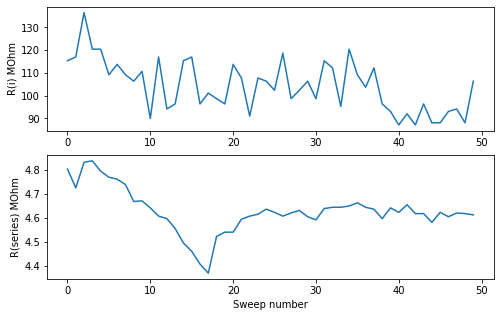

In [494]:
# Plot
Ri, Rs = get_resistances(real_mV, step_start, step_end, abf)

fig = plt.figure(figsize=(8, 5))

ax1 = fig.add_subplot(211)
plt.plot(abf.sweepList[0:50],Ri[0:50])
ax1.set_ylabel('R(i) MOhm')

ax2 = fig.add_subplot(212)
plt.plot(abf.sweepList[0:50],Rs[0:50])
ax2.set_ylabel('R(series) MOhm')
ax2.set_xlabel('Sweep number')

-5.0